In [1]:
import pandas as pd
import missingno as msno
from datetime import datetime
import numpy as np
import sklearn.compose._column_transformer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customers = pd.read_csv("../data/olist_customers_dataset.csv") # Client
geolocalisation = pd.read_csv("../data/olist_geolocation_dataset.csv") # Loc

order_items = pd.read_csv("../data/olist_order_items_dataset.csv") # Commandes items
order_payments = pd.read_csv("../data/olist_order_payments_dataset.csv") # Commandes paiement
order_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv") # Commandes reviews
orders = pd.read_csv("../data/olist_orders_dataset.csv") # Commandes

sellers = pd.read_csv("../data/olist_sellers_dataset.csv") # Vendeurs
products = pd.read_csv("../data/olist_products_dataset.csv") # Produits
cat_trans = pd.read_csv('../data/product_category_name_translation.csv') # Translate


In [3]:
order_cust = pd.merge(left=customers, right=orders, how="left", left_on="customer_id", right_on="customer_id")
forder_cust = pd.merge(left=order_cust, right=order_items, how="outer", left_on="order_id", right_on="order_id")

forder_cust['total'] = forder_cust[["price", "freight_value"]].sum(axis=1)

## Recence 

In [4]:
dates = ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']
forder_cust[dates] =forder_cust[dates].apply(pd.to_datetime, format='%Y-%m-%d')
date_1 = forder_cust.sort_values(by ='order_approved_at',ascending = False)


recence = date_1.groupby('customer_unique_id').agg(last_date =('order_approved_at','max')).reset_index()


recence['periode']=(date_1.order_approved_at.max()-recence.last_date).dt.days
recence.dropna(inplace=True)
recence.periode = recence.periode.astype(int)

def recence_transform(row):
    if row['periode'] <= 140:
        return 1
    if row['periode']> 140 and row['periode'] <= 280:
        return 2
    if row['periode']>280 and row['periode'] <= 420:
        return 3
    if row['periode']> 420 and row['periode'] <= 560:
        return 4
    if row['periode']> 560:
        return 5 

recence['r_value']=recence.apply(lambda row: recence_transform(row),axis=1)
recence.head()

,customer_unique_id,last_date,periode,r_value
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,116,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,118,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541,4
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,325,3
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,292,3


In [5]:

liste1 =cat_trans.product_category_name.tolist()
liste2 = cat_trans.product_category_name_english.tolist()
dict = {}
for key in liste1:
    for value in liste2:
        dict[key] = value
        liste2.remove(value)
        break
products.product_category_name=products.product_category_name.map(dict)
order_reviews.drop(['review_comment_title','review_comment_message'],inplace=True,axis=1)
order_reviews['review_score'].dropna(inplace=True)

## Merging pour l'analyse des commandes

### reajustement du df payments pour obtenir une ligne = une commande

In [6]:
def get_mode(x):
    return x.mode().iloc[0]

In [7]:
p1 = order_payments.groupby('order_id').agg(payment_installment = ('payment_installments',get_mode),payment_type = ('payment_type',get_mode),total_pay =('payment_value','sum')).reset_index()


### Merging products and order_items et les regrouper par commandes uniques

In [8]:
order_items.drop(['seller_id','price','freight_value'],inplace=True,axis=1)
products_item = pd.merge(order_items,products,how ='left',left_on='product_id',right_on='product_id')
a = products_item.groupby(['order_id','product_category_name']).agg(total_commande=('order_item_id','count'),prod =('product_id','nunique')).reset_index()
c = a.groupby('order_id').agg(category=('product_category_name',get_mode),items_commande = ('total_commande','sum'),prod_commande=('prod','sum')).reset_index()
df_commande = pd.merge(p1,c,how='left',left_on='order_id',right_on='order_id')
df_commande
#Dataframe montrant par commande , le type de paiement le plus utilisé, le total de la commande en R$, la catégorie du produit le plus commandé, le nb d'items commandé et le nombre de produits différents commandés


,order_id,payment_installment,payment_type,total_pay,category,items_commande,prod_commande
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19,cool_stuff,1.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83,pet_shop,1.0,1.0
2,000229ec398224ef6ca0657da4fc703e,5,credit_card,216.87,furniture_decor,1.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card,25.78,perfumery,1.0,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card,218.04,garden_tools,1.0,1.0
...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1,boleto,343.40,housewares,1.0,1.0
99436,fffcd46ef2263f404302a634eb57f7eb,1,boleto,386.53,computers_accessories,1.0,1.0
99437,fffce4705a9662cd70adb13d4a31832d,3,credit_card,116.85,sports_leisure,1.0,1.0
99438,fffe18544ffabc95dfada21779c9644f,3,credit_card,64.71,computers_accessories,1.0,1.0


### Merging orders_items/products/payments

In [9]:
orders=orders.dropna()
orders[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date']]= orders[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date']].apply(pd.to_datetime)
orders['purchase_date']=orders.order_purchase_timestamp.dt.to_period('M')
orders['approval_time']= (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.days
orders['delivery_time'] = (orders['order_delivered_customer_date']-orders['order_purchase_timestamp']).dt.days
orders.delivery_time =orders.delivery_time.astype(int)
df_orders = orders[['order_id','customer_id','delivery_time','purchase_date']]

In [10]:
df_commande.category.nunique()

71

In [11]:
df_client = pd.merge(df_commande,df_orders,how='left',left_on='order_id',right_on='order_id')

In [12]:
df_client['months']=df_client.purchase_date.dt.month
season_dict = {1: 'Winter',
               2: 'Winter',
               3: 'Spring', 
               4: 'Spring',
               5: 'Spring',
               6: 'Summer',
               7: 'Summer',
               8: 'Summer',
               9: 'Autumn',
               10: 'Autumn',
               11: 'Autumn',
               12: 'Winter'}
df_client['Season'] = df_client['months'].map(season_dict)

In [13]:
df_client.category.nunique()

71

### REVIEW

In [14]:
df_review = order_reviews.groupby('order_id',).agg(rating = ('review_score','mean'),review = ('review_id','count')).reset_index()


### Merging df_client et df_review

In [15]:
df_merge = pd.merge(df_client,df_review,how='left',left_on='order_id',right_on='order_id')
df_merge

,order_id,payment_installment,payment_type,total_pay,category,items_commande,prod_commande,customer_id,delivery_time,purchase_date,months,Season,rating,review
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19,cool_stuff,1.0,1.0,3ce436f183e68e07877b285a838db11a,7.0,2017-09,9,Autumn,5.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83,pet_shop,1.0,1.0,f6dd3ec061db4e3987629fe6b26e5cce,16.0,2017-04,4,Spring,4.0,1.0
2,000229ec398224ef6ca0657da4fc703e,5,credit_card,216.87,furniture_decor,1.0,1.0,6489ae5e4333f3693df5ad4372dab6d3,7.0,2018-01,1,Winter,5.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card,25.78,perfumery,1.0,1.0,d4eb9395c8c0431ee92fce09860c5a06,6.0,2018-08,8,Summer,4.0,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card,218.04,garden_tools,1.0,1.0,58dbd0b2d70206bf40e62cd34e84d795,25.0,2017-02,2,Winter,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1,boleto,343.40,housewares,1.0,1.0,b51593916b4b8e0d6f66f2ae24f2673d,17.0,2018-04,4,Spring,5.0,1.0
99436,fffcd46ef2263f404302a634eb57f7eb,1,boleto,386.53,computers_accessories,1.0,1.0,84c5d4fbaf120aae381fad077416eaa0,9.0,2018-07,7,Summer,5.0,1.0
99437,fffce4705a9662cd70adb13d4a31832d,3,credit_card,116.85,sports_leisure,1.0,1.0,29309aa813182aaddc9b259e31b870e6,4.0,2017-10,10,Autumn,5.0,1.0
99438,fffe18544ffabc95dfada21779c9644f,3,credit_card,64.71,computers_accessories,1.0,1.0,b5e6afd5a41800fdf401e0272ca74655,1.0,2017-08,8,Summer,5.0,1.0


In [16]:
df_merge2 = pd.merge(df_merge,customers,how='left',left_on='customer_id',right_on='customer_id')
df_merge2.drop(['customer_id','customer_zip_code_prefix'],axis=1,inplace=True)
df_merge2.dropna()
df_merge2.category.fillna('None',inplace=True)
sum_list = ['total_pay','items_commande','prod_commande','review']
mod_list = ['customer_city','customer_state','category','payment_type']#,'payment_type','category']
max_list = ['purchase_date']
last_list = ['Season','months']
mean_list = ['rating','delivery_time','payment_installment','freight_value','product_description_lenght','total_size']
count_list = ['order_id']
d1 = dict.fromkeys(sum_list, 'sum')
d2 = dict.fromkeys(mod_list, get_mode)
d3 = dict.fromkeys(max_list,'max')
d4 = dict.fromkeys(last_list,'last')
d5 = dict.fromkeys(mean_list,'mean')
d6 = dict.fromkeys(count_list,'count')
d = {**d1, **d2,**d3,**d4,**d5,**d6}

In [18]:
order_items = pd.read_csv("../data/olist_order_items_dataset.csv") # Commandes items
products = pd.read_csv("../data/olist_products_dataset.csv") # Produits

In [19]:
products['total_size']=products.product_height_cm*products.product_length_cm*products.product_width_cm

jpp = pd.merge(order_items,products,how='left',left_on='product_id',right_on='product_id')
jpp = jpp.groupby('order_id').agg({'freight_value':'mean','total_size':'mean','product_description_lenght':'mean'}).reset_index()
jpp

,order_id,freight_value,total_size,product_description_lenght
0,00010242fe8c5a6d1ba2dd792cb16214,13.29,3528.0,598.0
1,00018f77f2f0320c557190d7a144bdd3,19.93,60000.0,239.0
2,000229ec398224ef6ca0657da4fc703e,17.87,14157.0,695.0
3,00024acbcdf0a6daa1e931b038114c75,12.79,2400.0,480.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,18.14,42000.0,409.0
...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,43.41,53400.0,1002.0
98662,fffcd46ef2263f404302a634eb57f7eb,36.53,44460.0,232.0
98663,fffce4705a9662cd70adb13d4a31832d,16.95,9576.0,869.0
98664,fffe18544ffabc95dfada21779c9644f,8.72,8000.0,1306.0


In [20]:
df_merge3 = pd.merge(df_merge2,jpp,how='left',left_on='order_id',right_on='order_id')
df_merge3

,order_id,payment_installment,payment_type,total_pay,category,items_commande,prod_commande,delivery_time,purchase_date,months,Season,rating,review,customer_unique_id,customer_city,customer_state,freight_value,total_size,product_description_lenght
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19,cool_stuff,1.0,1.0,7.0,2017-09,9,Autumn,5.0,1.0,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,13.29,3528.0,598.0
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83,pet_shop,1.0,1.0,16.0,2017-04,4,Spring,4.0,1.0,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,SP,19.93,60000.0,239.0
2,000229ec398224ef6ca0657da4fc703e,5,credit_card,216.87,furniture_decor,1.0,1.0,7.0,2018-01,1,Winter,5.0,1.0,3818d81c6709e39d06b2738a8d3a2474,para de minas,MG,17.87,14157.0,695.0
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card,25.78,perfumery,1.0,1.0,6.0,2018-08,8,Summer,4.0,1.0,af861d436cfc08b2c2ddefd0ba074622,atibaia,SP,12.79,2400.0,480.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card,218.04,garden_tools,1.0,1.0,25.0,2017-02,2,Winter,5.0,1.0,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,SP,18.14,42000.0,409.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1,boleto,343.40,housewares,1.0,1.0,17.0,2018-04,4,Spring,5.0,1.0,0c9aeda10a71f369396d0c04dce13a64,sao luis,MA,43.41,53400.0,1002.0
99436,fffcd46ef2263f404302a634eb57f7eb,1,boleto,386.53,computers_accessories,1.0,1.0,9.0,2018-07,7,Summer,5.0,1.0,0da9fe112eae0c74d3ba1fe16de0988b,curitiba,PR,36.53,44460.0,232.0
99437,fffce4705a9662cd70adb13d4a31832d,3,credit_card,116.85,sports_leisure,1.0,1.0,4.0,2017-10,10,Autumn,5.0,1.0,cd79b407828f02fdbba457111c38e4c4,sao paulo,SP,16.95,9576.0,869.0
99438,fffe18544ffabc95dfada21779c9644f,3,credit_card,64.71,computers_accessories,1.0,1.0,1.0,2017-08,8,Summer,5.0,1.0,eb803377c9315b564bdedad672039306,vinhedo,SP,8.72,8000.0,1306.0


In [21]:
df_last = df_merge3.groupby('customer_unique_id').agg(d).reset_index()
rfm = pd.read_csv('data.csv')
rfm.drop(['zipcode','city','state','total','no_purchase_period'],axis=1,inplace=True)

In [31]:
df = pd.merge(df_last,rfm,how='left',left_on='customer_unique_id',right_on = 'id')
df.drop(['id','last_purchase','customer_unique_id'],axis=1,inplace=True)
df.dropna(how = 'any',inplace=True)

In [32]:
transformer = {'Meubles et décoration': ['bed_bath_table','furniture_decor','office_furniture','home_comfort_2','home_confort', 'housewares', 'furniture_living_room','kitchen_dining_laundry_garden_furniture', 'furniture_bedroom','furniture_mattress_and_upholstery'],
                'Électronique et informatique': ['audio','fixed_telephony','telephony', 'computers_accessories', 'electronics', 'consoles_games', 'computers', 'signaling_and_security','tablets_printing_image', 'cds_dvds_musicals', 'dvds_blu_ray', 'music'],
                'Santé et beauté': ['health_beauty', 'perfumery'],
                'Mode et accessoires': ['fashion_bags_accessories', 'fashion_underwear_beach', 'fashion_shoes', 'fashion_male_clothing', 'fashion_sport', 'luggage_accessories','fashio_female_clothing', 'fashion_childrens_clothes'],
                'Petits appareils ménagers': ['home_appliances','home_appliances_2','small_appliances', 'small_appliances_home_oven_and_coffee', 'air_conditioning'],
                'Outils et matériaux de construction': ['construction_tools_construction','construction_tools_safety','construction_tools_construction,' 'construction_tools_safety', 'construction_tools_lights', 'costruction_tools_garden', 'costruction_tools_tools','home_construction'],
                'Loisirs et sports':['sports_leisure', 'garden_tools', 'musical_instruments', 'cool_stuff', 'toys', 'books_general_interest', 'books_technical', 'books_imported', 'cine_photo', 'art', 'arts_and_craftmanship'],
                'Autres': ['stationery',  'watches_gifts', 'auto', 'christmas_supplies', 'drinks','baby', 'pet_shop', 'market_place', 'flowers', 'industry_commerce_and_business', 'food_drink', 'food', 'agro_industry_and_commerce', 'party_supplies', 'diapers_and_hygiene', 'security_and_services','la_cuisine'],
                'Inconnu' : ['None']
}        
keys =transformer.keys()
for key in keys:
  df.category = df.category.replace(to_replace=transformer[key], value=key)


In [33]:
df.columns =['total_pay', 'nb_total_items_commande', 'nb_prod_different', 'nb_review',
       'customer_city', 'customer_state', 'category', 'payment_type','purchase_date','Season',
       'months', 'rating_review', 'delivery_time', 'payment_installment',
       'freight_value', 'product_description_lenght', 'total_size', 'nb_total_commande',
       'freq', 'recense', 'montant']

In [34]:
df['panier_moyen']=df['total_pay']/df['nb_total_commande']
df.drop(['customer_city','customer_state'],axis=1,inplace=True)
df.to_csv('merged.csv',index=False)


### TESST

In [35]:
merged = pd.read_csv('merged.csv')
df = merged.copy()
df.recense = df.recense +3
df.freq = df.freq +3 
df.drop()


In [61]:
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,FunctionTransformer,StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
from kmodes.kprototypes import KPrototypes

## Clustering 2017

In [56]:
df.sort_values('purchase_date',ascending=False,inplace=True)
df['Year']=df.purchase_date.astype(str).str[0:4]

In [74]:
df_2017 = df[df.Year=='2017'].drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','total_pay'],axis=1)
df_2017_index = df_2017.index.tolist()

In [62]:
def log(x):
    return np.log1p(abs(x))
transformer = FunctionTransformer(log)
transformer2 = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (transformer,make_column_selector(dtype_include=np.number))
    )

In [63]:
new_columns = df_2017.select_dtypes(np.number).columns.tolist()+df_2017.select_dtypes(object).columns.to_list()
scaler = make_column_transformer((transformer,make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
normalize =make_column_transformer((StandardScaler(),make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
df_t = scaler.fit_transform(df_2017)
test = pd.DataFrame(df_t,columns=new_columns)


,rating_review,delivery_time,payment_installment,freight_value,product_description_lenght,total_size,nb_total_commande,freq,recense,montant,panier_moyen,category,payment_type
0,1.791759,2.197225,0.693147,2.778819,5.902633,7.390799,0.693147,1.386294,1.386294,0.693147,3.999668,Loisirs et sports,credit_card
1,0.693147,3.091042,0.693147,2.778819,5.996452,8.489411,0.693147,1.386294,1.386294,0.693147,4.043051,Électronique et informatique,credit_card
2,1.386294,2.944439,1.098612,2.782539,5.736572,6.977281,0.693147,1.386294,1.386294,0.693147,4.312944,Autres,credit_card
3,0.693147,3.218876,1.098612,2.842581,5.945421,9.798183,0.693147,1.386294,1.386294,0.693147,4.30609,Meubles et décoration,credit_card
4,1.791759,2.944439,2.397895,3.099191,7.131699,6.781058,0.693147,1.386294,1.386294,1.94591,5.701012,Autres,credit_card
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40461,1.791759,2.484907,0.693147,2.84135,6.509762,8.855663,1.386294,1.386294,1.386294,2.079442,4.7706,Loisirs et sports,boleto
40462,1.098612,2.397895,2.397895,2.834389,7.920083,9.474319,0.693147,1.386294,1.386294,1.386294,4.990501,Loisirs et sports,credit_card
40463,1.791759,2.197225,0.693147,2.944439,6.318968,9.230829,0.693147,1.386294,1.386294,0.693147,3.988984,Autres,credit_card
40464,1.609438,1.791759,0.693147,2.481568,5.590987,6.44254,0.693147,1.386294,1.386294,0.693147,3.553918,Électronique et informatique,boleto


In [68]:
k = 5
df_test =normalize.fit_transform(test)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters = model.fit_predict(df_t, categorical=[11,12])


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 5, iteration: 1/50, moves: 15649, ncost: 96438.8646934393
Run: 1, iteration: 1/50, moves: 11409, ncost: 96964.80254138878
Run: 4, iteration: 1/50, moves: 10648, ncost: 93903.47095626043
Run: 3, iteration: 1/50, moves: 13688, ncost: 94584.07702217471
Run: 2, iteration: 1/50, moves: 12544, ncost: 95789.82101670645
Run: 5, iteration: 2/50, moves: 4305, ncost: 95235.67473557466
Run: 1, iteration: 2/50, moves: 6837, ncost: 93809.2542320306
Run: 4, iteration: 2/50, moves: 5746, ncost: 91822.1441358754
Run: 3, iteration:

In [69]:
clusters_list = []
for c in clusters:
    clusters_list.append(c)

## CLUSTERING 2017 N+3


In [77]:
df.purchase_date = pd.to_datetime(df.purchase_date)


,total_pay,nb_total_items_commande,nb_prod_different,nb_review,category,payment_type,purchase_date,Season,months,rating_review,...,payment_installment,freight_value,product_description_lenght,total_size,nb_total_commande,freq,recense,montant,panier_moyen,Year
24590,88.26,1.0,1.0,1.0,Autres,boleto,2018-08-01,Summer,8,5.0,...,1.0,23.26,791.0,19200.0,1,6,13.0,2,88.26,2018
37244,674.82,1.0,1.0,1.0,Santé et beauté,credit_card,2018-08-01,Summer,8,5.0,...,10.0,26.82,3866.0,4800.0,1,6,13.0,10,674.82,2018
65062,26.38,1.0,1.0,1.0,Électronique et informatique,credit_card,2018-08-01,Summer,8,4.0,...,1.0,7.39,517.0,1344.0,1,6,13.0,1,26.38,2018
82594,192.03,1.0,1.0,1.0,Meubles et décoration,credit_card,2018-08-01,Summer,8,5.0,...,3.0,42.03,616.0,31500.0,1,6,13.0,4,192.03,2018
37167,195.61,1.0,1.0,1.0,Électronique et informatique,boleto,2018-08-01,Summer,8,5.0,...,1.0,15.71,977.0,4800.0,1,6,13.0,4,195.61,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89606,65.46,1.0,1.0,1.0,Santé et beauté,credit_card,2016-10-01,Autumn,10,3.0,...,1.0,15.56,565.0,5100.0,1,3,3.0,1,65.46,2016
63888,89.16,1.0,1.0,1.0,Loisirs et sports,credit_card,2016-10-01,Autumn,10,5.0,...,2.0,19.26,1115.0,13800.0,1,3,3.0,2,89.16,2016
27160,214.98,1.0,1.0,1.0,Électronique et informatique,credit_card,2016-10-01,Autumn,10,5.0,...,7.0,15.98,607.0,1768.0,1,3,3.0,4,214.98,2016
79586,71.21,1.0,1.0,1.0,Santé et beauté,credit_card,2016-10-01,Autumn,10,5.0,...,1.0,11.31,1739.0,8000.0,1,3,3.0,1,71.21,2016


In [89]:
df_2017_n3 = df[(df.purchase_date >= '2017') & (df.purchase_date <= '2018-03')].drop(['purchase_date','months','Season','months','Year','nb_prod_different','nb_review','nb_total_items_commande','total_pay'],axis=1)

In [90]:
new_columns = df_2017_n3.select_dtypes(np.number).columns.tolist()+df_2017_n3.select_dtypes(object).columns.to_list()
scaler = make_column_transformer((transformer,make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
normalize =make_column_transformer((StandardScaler(),make_column_selector(dtype_include=np.number)),
remainder='passthrough'
)
df_t2 = scaler.fit_transform(df_2017_n3)
test = pd.DataFrame(df_t2,columns=new_columns)

In [ ]:
k = 5
df_test =normalize.fit_transform(test)
model = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_jobs=-1, n_init=5, max_iter=50, random_state=42)

clusters = model.fit_predict(df_t2, categorical=[11,12])


## PCA

In [ ]:
# preprocessing = make_pipeline(transformer2,MinMaxScaler())
pca = make_pipeline(transformer2,PCA(n_components=0.95))
components = pca.fit_transform(df_2017_n3)
df_pca = pd.DataFrame(components)
df_pca['cluster'] = clusters_list


<AxesSubplot:xlabel='0', ylabel='1'>

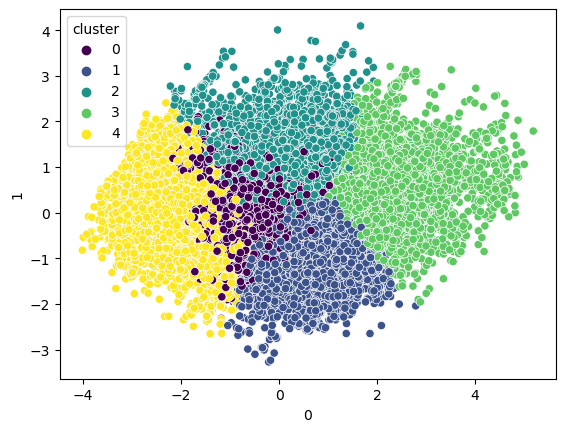

In [72]:
sns.scatterplot(data=df_pca,x=df_pca.iloc[:,0],y=df_pca.iloc[:,1],hue='cluster',palette='viridis')

In [ ]:
# graph = components[:, 0:2]


# loadings = graph

# fig = px.scatter(graph, x=0, y=1, color=df_pca['cluster'])

# for i, feature in enumerate(new_columns):
#     fig.add_annotation(
#         ax=0, ay=0,
#         axref="x", ayref="y",
#         x=loadings[i, 0],
#         y=loadings[i, 1],
#         showarrow=True,
#         arrowsize=2,
#         arrowhead=2,
#         xanchor="right",
#         yanchor="top"
#     )
#     fig.add_annotation(
#         x=loadings[i, 0],
#         y=loadings[i, 1],
#         ax=0, ay=0,
#         xanchor="center",
#         yanchor="bottom",
#         text=feature,
#         yshift=5,
#     )
# fig.show()


### Clustering 2017 N+3

## Analyse

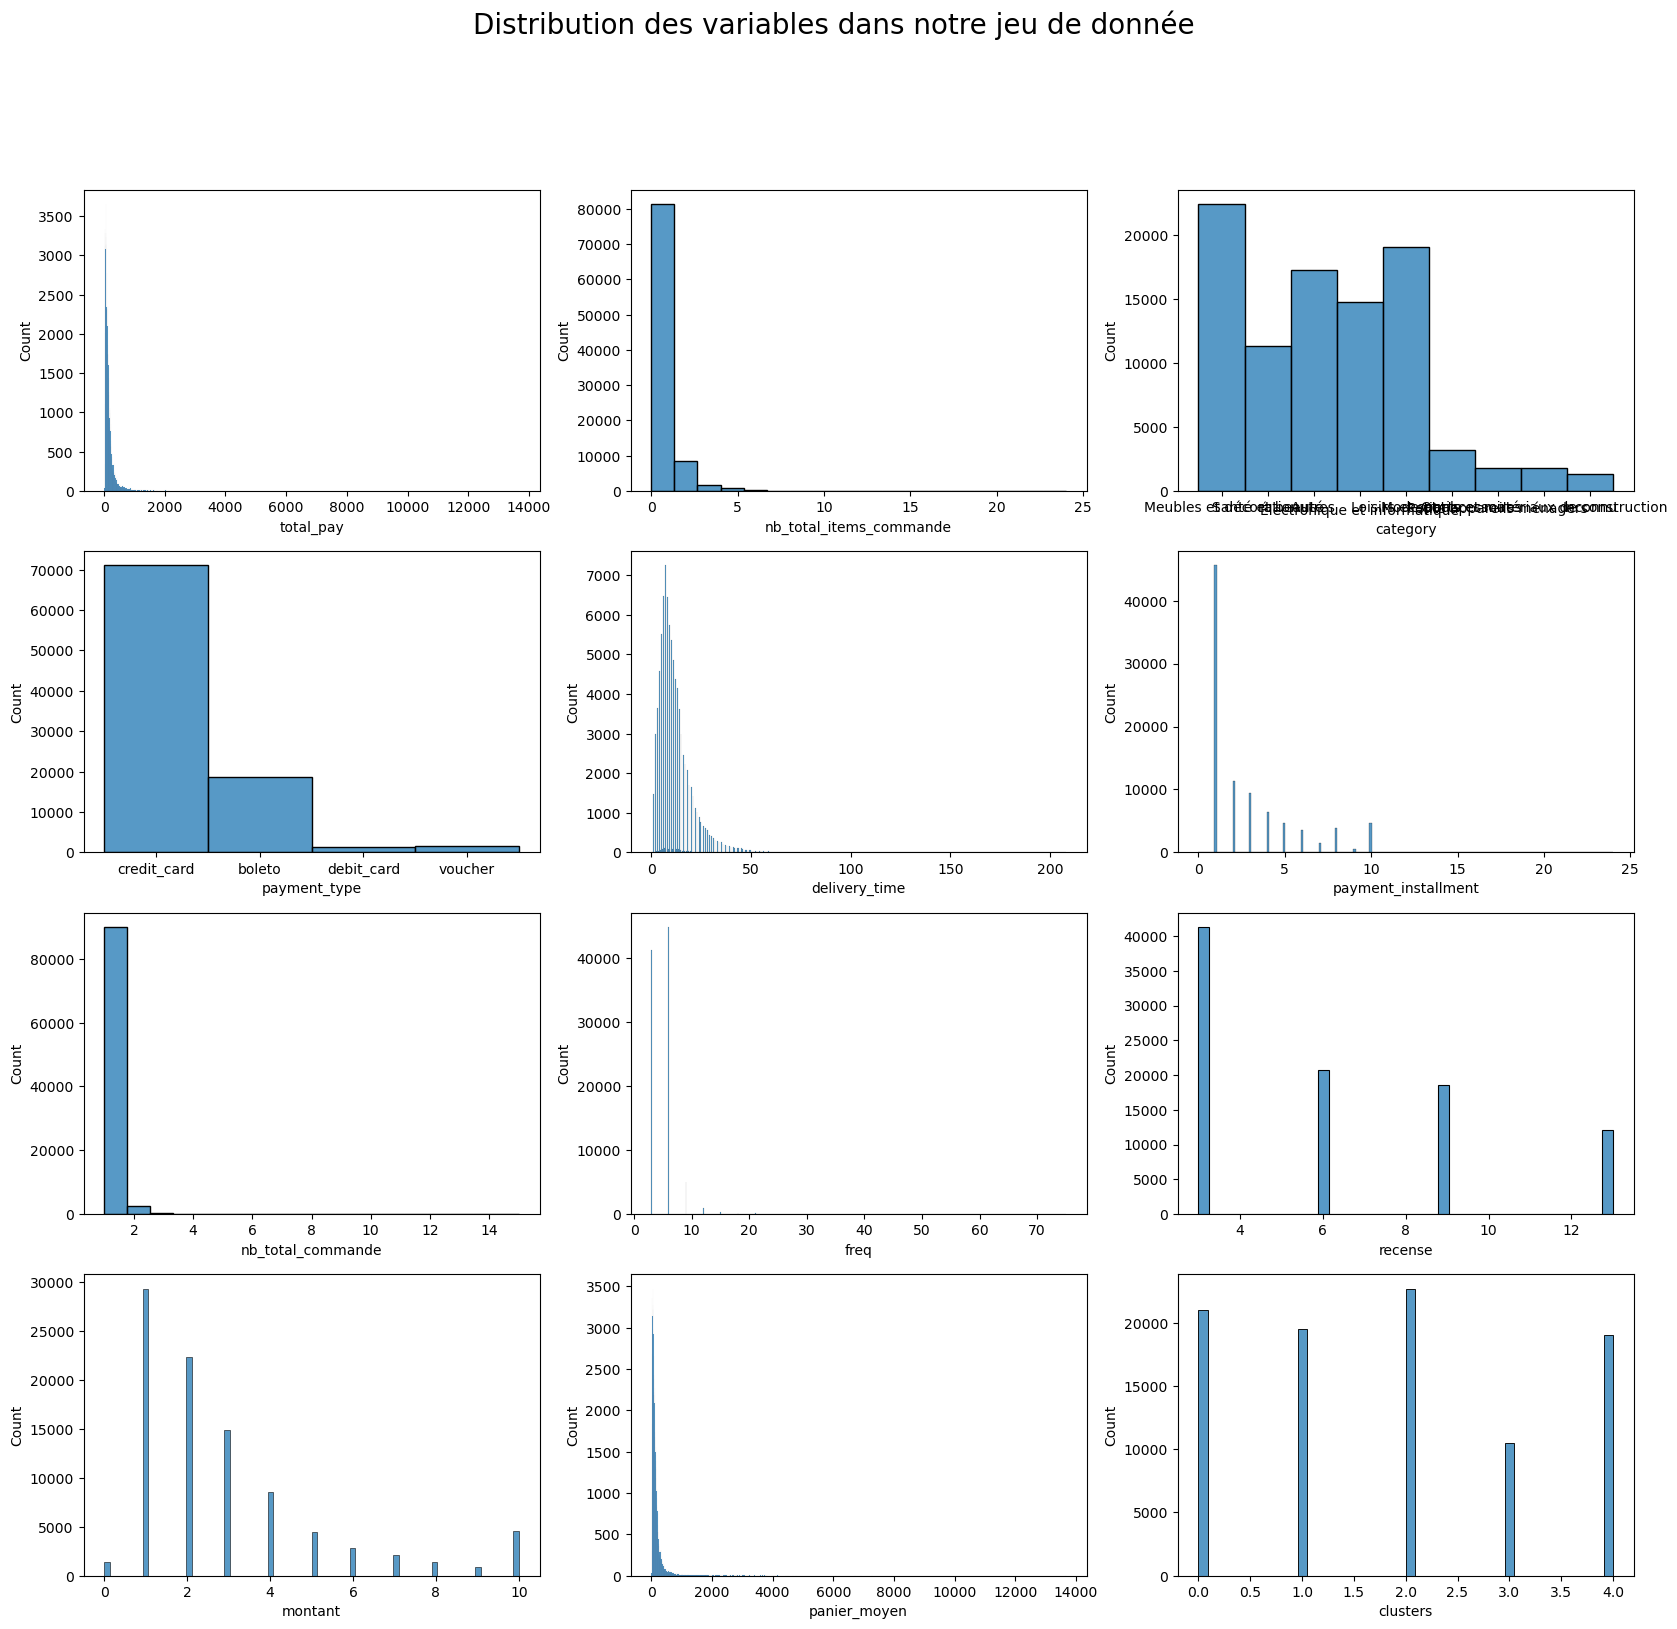

In [ ]:
fig, ax =plt.subplots(4,3,figsize=(20,18))
plt.suptitle("Distribution des variables dans notre jeu de donnée",fontsize =20)
n=0
p=0
for name in df.columns.tolist():
    sns.histplot(ax=ax[n,p],x=name,data=df)
    if p ==0 or p%2!=0:
        p+=1
    elif p == 2 :
        p=0
        n+=1

In [ ]:
mms = MinMaxScaler(feature_range =(1,5))

In [ ]:
clusters_means = df.select_dtypes(np.number).drop('clusters',axis=1)
cmn= clusters_means.columns.tolist()

In [ ]:
df_clusters = pd.DataFrame(mms.fit_transform(clusters_means),columns =cmn)
df_clusters['clusters']=clusters_list
df_clusters= df_clusters.groupby('clusters').agg('median').reset_index()

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_clusters.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=cmn,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)